In [6]:
from array import *
import pandas as pd
import sqlalchemy as db
import datetime 
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import numpy as np
import os

%load_ext sql
%load_ext dotenv

%sql postgresql://$POSTGRES_USER:$POSTGRES_PWD@db/registry

conn_str = 'postgresql://%s:%s@db/registry' % (os.getenv("POSTGRES_USER"), os.getenv("POSTGRES_PWD"))
engine = db.create_engine(conn_str)
connection = engine.connect()

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [2]:
%%sql
SELECT 
  round(sum(container_cpu_usage_sum)::numeric, 2) AS usage,
  round(sum(container_cpu_requests_sum)::numeric, 2) AS request,
  round((sum(container_cpu_usage_sum)/sum(container_cpu_requests_sum)*100)::numeric, 2) AS usage_pct,
  date_trunc('day', created_at) AS date
FROM resource_usage 
GROUP BY date_trunc('day', created_at)
ORDER BY date_trunc('day', created_at)

 * postgresql://app_api_704fkrus:***@db/registry
28 rows affected.


usage,request,usage_pct,date
69.94,825.65,8.47,2022-07-05 00:00:00
66.33,799.48,8.30,2022-07-12 00:00:00
73.59,804.06,9.15,2022-07-18 00:00:00
69.47,802.84,8.65,2022-07-25 00:00:00
79.09,794.91,9.95,2022-08-02 00:00:00
65.55,788.19,8.32,2022-08-08 00:00:00
73.77,784.58,9.40,2022-08-30 00:00:00
76.25,783.26,9.73,2022-09-06 00:00:00
63.99,769.64,8.31,2022-11-21 00:00:00
67.45,784.83,8.59,2022-11-28 00:00:00


/tmp/ipykernel_1047/3077936271.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['nil', '2022-07-05', '2022-08-08', '2022-12-05', '2023-01-16', '2023-02-28', '2023-05-24'])


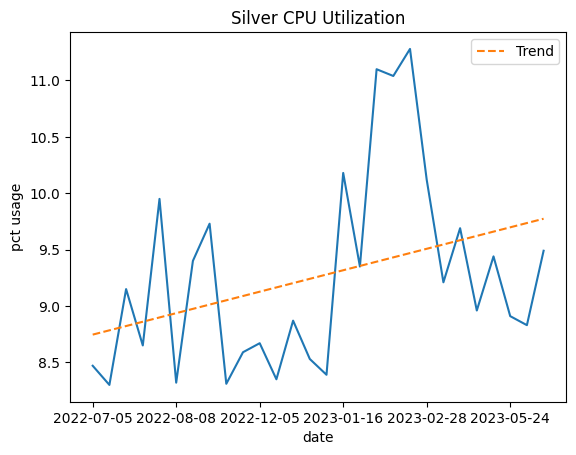

In [3]:
query = '''
SELECT 
  round((sum(container_cpu_usage_sum)/sum(container_cpu_requests_sum)*100)::numeric, 2) AS usage_pct,
  date_trunc('day', created_at) AS date
FROM 
  resource_usage 
GROUP BY 
  date_trunc('day', created_at)
ORDER BY
  date_trunc('day', created_at);
'''

df = pd.read_sql(query, connection)
df.set_index('date', inplace=True)

fig, ax = plt.subplots()

# linear dates, use len of array and save as tick labels.
bestfit = stats.linregress(range(len(df.index)), df['usage_pct'])
label = str(round(bestfit[0],2)) + "x + " + str(round(bestfit[1],2)) 
label = 'Trend'

ax.plot(range(len(df.index)), df['usage_pct'])
ax.plot(range(len(df.index)), np.poly1d(np.polyfit(range(len(df.index)), df['usage_pct'], 1))(range(len(df.index))), '--',label=label)

# Set x and y labels.
ax.set_xlabel('date')
ax.set_ylabel('pct usage')

# Set date tick labels and legend
# plt.xticks(range(len(df.index)))
ax.set_xticklabels(['nil', '2022-07-05', '2022-08-08', '2022-12-05', '2023-01-16', '2023-02-28', '2023-05-24'])
plt.legend()
plt.title('Silver CPU Utilization')

plt.show()

In [24]:
query = '''
SELECT
  project.project_set_id AS namespace,
  project.name,
  project.ministry,
  project.project_owner_name,
  project.project_onwer_email,
  project.primary_technical_lead_name,
  project.primary_technical_lead_email,
  container_cpu_usage_sum AS usage,
  container_cpu_requests_sum AS request, 
  round((container_cpu_requests_sum - container_cpu_usage_sum)::numeric, 2) AS slack 
FROM 
  resource_usage
JOIN
  project ON project.project_set_id = resource_usage.project_set_id
WHERE 
  date_trunc('day', resource_usage.created_at) = date_trunc('day', now()::date)
ORDER BY
  slack 
DESC LIMIT 22;
'''

top_ten_df = pd.read_sql(query, connection)
top_ten_df.set_index('namespace', inplace=True)

In [ ]:
currentDate = datetime.date.today()
datestamp = currentDate.strftime("%Y%m%d")

print(top_ten_df)
# top_ten_df['slack'].sum()

top_ten_df.to_excel('/w/output-%s.xlsx' % datestamp, index=True)